# <a id='toc1_'></a>[Test case of threshold based method](#toc0_)

- Use of NorCP data, ALADIN 12 km
- Daily maxmimum convective precipitation
- Nordic sub-domain
- Checking for extreme days throughout one summer season (2008)


In [ ]:
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from dask.distributed import Client
# from xtrdet.methods import event_detection_algorithms
from xtrdet.preproc import get_configuration
# from xtrdet.preproc import preprocessing
from xtrdet.utils import open_data
from xtrdet.utils import resampling
from xtrdet.utils import spatial_masking
import cartopy.crs as ccrs

In [ ]:
def local_cluster_setup():
    """
    Set up local-pc cluster
    """
    from dask.distributed import LocalCluster
    cluster = LocalCluster(processes=False)
    return cluster

In [ ]:
def slurm_cluster_setup(nodes=1, **kwargs):
    """
    Set up SLURM cluster
    Parameters
    ----------
    nodes: int
        Number of nodes to use
    **kwargs:
        Keyword arguments for cluster specifications
    """
    from dask_jobqueue import SLURMCluster
    cluster = SLURMCluster(**kwargs)
    cluster.scale(nodes)
    return cluster

In [ ]:
def get_args():
    """
    Read configuration file
    Parameters
    ----------
    -
    Returns
    -------
    Input arguments
    """
    import argparse

    # Configuring argument setup and handling
    parser = argparse.ArgumentParser(
        description='Main script for model/obs validation')
    parser.add_argument('--config', '-c',  metavar='name config file',
                        type=str, help='<Required> Full path to config file',
                        required=True)
    return parser.parse_args()

### <a id='toc1_1_1_'></a>[Read configuration file](#toc0_)

In [ ]:
# Get configuration
config_file = '/home/sm_petli/dev/scripts/python/analysis/DEODE/extreme_event_detection/config_main.ini'  # noqa
configuration_dict = get_configuration.get_settings(config_file)
# Create dirs
outdir = configuration_dict['outdir']
if not os.path.exists(configuration_dict['outdir']):
    os.makedirs(outdir)

### <a id='toc1_1_2_'></a>[Starting a cluster](#toc0_)

In [ ]:
# Set up distributed client
if configuration_dict['cluster type'] == 'local':
    cluster = local_cluster_setup()
elif configuration_dict['cluster type'] == 'slurm':
    nnodes = configuration_dict['nodes']
    sl_kwargs = configuration_dict['cluster kwargs']
    cluster = slurm_cluster_setup(nodes=nnodes, **sl_kwargs)
else:
    print("\n\tCluster type not implemented! Exiting..")
    sys.exit()
client = Client(cluster)

In [ ]:
# Settings
var = 'pr'
region = 'Norcp Analysis Domain'

### <a id='toc1_1_3_'></a>[Open, mask & resample target data](#toc0_)

In [ ]:

# Target data
var_conf_trgt = configuration_dict['target data']['variables'][var]
target_conf = open_data.ReadInputData(configuration_dict['target data'])
trgt_data = target_conf.read_data(var)

In [ ]:

masking_trgt_data = spatial_masking.SpatialMasking(trgt_data, var)
trgt_msk_data = masking_trgt_data.get_mask(region, extract_data=True)

In [ ]:
res_freq, res_meth = var_conf_trgt['resample resolution']
resample = resampling.Resampling(res_freq, res_meth)
trgt_mask_resampled = resample.resample(trgt_msk_data)

### <a id='toc1_1_4_'></a>[... and the same for climatology data](#toc0_)

In [ ]:

# Climate data
var_conf_clim = configuration_dict['climatology data']['variables'][var]
clim_conf = open_data.ReadInputData(
    configuration_dict['climatology data'])
clim_data = clim_conf.read_data(var)

In [ ]:
clim_data

In [ ]:
masking_clm_data = spatial_masking.SpatialMasking(clim_data, var)
clim_msk_data = masking_clm_data.get_mask(region, extract_data=True)

In [ ]:
clim_msk_data

In [ ]:
res_freq, res_meth = var_conf_clim['resample resolution']
resample = resampling.Resampling(res_freq, res_meth)
clim_mask_resampled = resample.resample(clim_msk_data)

In [ ]:
clim_mask_resampled

## <a id='toc1_2_'></a>[Running event detection algorithm](#toc0_)

### <a id='toc1_2_1_'></a>[Work flow](#toc0_)
- Compute all grid point percentile threshold from climatology data
- Sum field values above threshold per day
- Extract top N % of summed daily fields - that's you're detected events!

In [ ]:
method_args = configuration_dict['method args']
percentile = method_args['threshold']['percentile']

In [ ]:
thr_clim = clim_mask_resampled.chunk({'time': -1, 'x': -1, 'y': -1}).quantile(percentile/100)

In [ ]:
trgt_sum_per_day = trgt_mask_resampled.where(trgt_mask_resampled[var] >= thr_clim, trgt_mask_resampled).sum(dim=('x', 'y'))

In [ ]:
foo = trgt_sum_per_day.load()

In [ ]:
# top10 = foo.where(foo[var] >= foo.quantile(1-(10/100))
selected_days = foo.sortby(var, ascending=False).isel(time=slice(0, int((10/100)*foo.time.size))).time

In [ ]:
extreme_days = trgt_mask_resampled.sel(time=selected_days)

## Visualization

In [55]:
trgt_data.Lambert_Conformal

<xarray.DataArray 'Lambert_Conformal' (time: 2208)>
array([1., 1., 1., ..., 1., 1., 1.])
Coordinates:
  * time     (time) datetime64[ns] 2008-06-01T00:30:00 ... 2008-08-31T23:30:00
Attributes:
    grid_mapping_name:              lambert_conformal_conic
    standard_parallel:              60.59999999999998
    longitude_of_central_meridian:  10.0
    latitude_of_projection_origin:  60.59999999999998
    false_easting:                  1762838.399481583
    false_northing:                 2086337.1006469233
    earth_radius:                   6371220.0
    proj4:                          +proj=lcca +lat_1=60.600000 +lat_0=60.600...

In [53]:
ccrs.LambertConformal?

Init signature:
ccrs.LambertConformal(
    central_longitude=-96.0,
    central_latitude=39.0,
    false_easting=0.0,
    false_northing=0.0,
    standard_parallels=(33, 45),
    globe=None,
    cutoff=-30,
)
Docstring:      A Lambert Conformal conic projection.
Init docstring:
Parameters
----------
central_longitude: optional
    The central longitude. Defaults to -96.
central_latitude: optional
    The central latitude. Defaults to 39.
false_easting: optional
    X offset from planar origin in metres. Defaults to 0.
false_northing: optional
    Y offset from planar origin in metres. Defaults to 0.
standard_parallels: optional
    Standard parallel latitude(s). Defaults to (33, 45).
globe: optional
    A :class:`cartopy.crs.Globe`. If omitted, a default globe is
    created.
cutoff: optional
    Latitude of map cutoff.
    The map extends to infinity opposite the central pole
    so we must cut off the map drawing before then.
    A value of 0 will draw half the globe. Defaults to -30

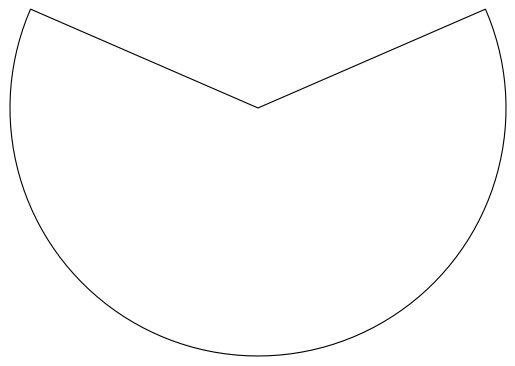

In [56]:
# fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.LambertConformal(10, 60.6)))

In [57]:
fg = extreme_days[var].plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={
        'projection': ccrs.LambertConformal(
            central_longitude=10.0, central_latitude=60.6
        )
    },
    col='time',
    col_wrap=3,
    robust=True,
    cbar_kwargs={
        'orientation': 'horizontal',
        'pad': 0.1,
        'aspect': 40,
        'shrink': 0.8,
    },
)
fg.map(lambda: plt.gca().coastlines())

ValueError: Can't use axes when making faceted plots.

In [ ]:

"""
extreme_detection = event_detection_algorithms.ExtremeDetectionAlgorithm(algorithm, var)
days_of_extreme_detected = extreme_detection.threshold_based_algorithm(filter_method, pctl_threshold, perc_of_days)
Evaluation()
PostProcessing()
UnitTest()
"""

In [ ]:
cluster.close()